****
### Import librairies
****

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from lightgbm import plot_importance
from imblearn.pipeline import Pipeline

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score

from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import SMOTE

In [2]:
# Remove fraud_count as it's only 0
df = pd.read_csv("../data/Base.csv")
df = df.drop(['device_fraud_count'], axis=1, errors='ignore') 

X = df.drop(['fraud_bool'], axis = 1)
y = df['fraud_bool']

**** 
### Feature Engineering
****

Due to time constraints, we don't further develop this section here as the dataset already seems clean. However, to improve the predictive power, we could try to perfrom further feature engineering task:
- Identify the highly correlated regressors and drop them to avoid redundancy (Correlation matrix)
- Simple sensitivity analysis w.r.t. the target variable by calculating the correlation/mutual information with fraud_bool to identify the most important features. 
- We can evaluate the correlation through statistical tests for selection. 
- Maybe apply some logarithmic transformation to features that are heavily skewed (or that seem to have a lot of outliers far away from the median)  

****
### Data Processing
****

In [3]:
#one hot encoding the categorical features
X = pd.get_dummies(X)
X.shape

(1000000, 51)

In [4]:
# Train-Test split: Random shuffling and not month selection
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [5]:
#MinMax scaler 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
print(f"Proportion of frauds in train dataset: {y_train.sum()/len(y_train)}")
print(f"Proportion of frauds in train dataset: {y_test.sum()/len(y_test)}")

Proportion of frauds in train dataset: 0.011132835820895522
Proportion of frauds in train dataset: 0.010818181818181819


****
### Training
****

Dealing with an imbalanced dataset is complex, and can lead to several problems: 
- The model might prioritize the not Fraud class to optimize its loss leading to a biased model
- Poor generalisation on the Fraud class

Common ideas to deal with imbalanced dataset is undersampling (randomly selecting a subset of not Fraud) or oversampling (generating synthetic Fraud points). The former is the easier method to apply, but there can be some loss of information. The second one keep all the information in the dataset, but is also more difficult and costly to apply. I did it on synthetic aircraft trajectories using a VAE and combining the VAE latent space with Subset Sampling to generate a greater amount of colliding pairs of trajectories. For simplier applications like here, it exists more straight forward methods such as random upsampling (dupplicating), or SMOTE (Synthetic Minority Oversampling Technique). 

SMOTE is based on the kNN. It identifies a Fraud sample, and identify the k nearest fraud samples in the feature space. It randomly selects one of the neighbour, and generates a new fraud sample by making a weighted sum. However, SMOTE suppose that the distribution of the Fraud sample within the feature space is continuous and complete, which might not be always the case: it's not because a sample is close to a Fraud Sample that it is necessarily a Fraud. (e.g. pairs of colliding trajectories). It can necessitate further inversigations if the model doesn't properly work. 

NB: If we use Cross-validation, we have to apply it BEFORE SMOTE. Otherwise, SMOTE could affect the distribution of the validation set. In this project, we don't implement CV or GridSearch because SMOTE is already time consumming. 


In [7]:
#Identify ohe features
encoded_features = [X_train.columns.get_loc(str(feature)) for feature in X_train.columns if X_train[feature].nunique() == 2]
print(X_train.columns[encoded_features])

smote = SMOTENC(categorical_features=encoded_features, sampling_strategy="minority", random_state=42) #SMOTE NC handles categorical features

Index(['email_is_free', 'phone_home_valid', 'phone_mobile_valid',
       'has_other_cards', 'foreign_request', 'keep_alive_session',
       'payment_type_AA', 'payment_type_AB', 'payment_type_AC',
       'payment_type_AD', 'payment_type_AE', 'employment_status_CA',
       'employment_status_CB', 'employment_status_CC', 'employment_status_CD',
       'employment_status_CE', 'employment_status_CF', 'employment_status_CG',
       'housing_status_BA', 'housing_status_BB', 'housing_status_BC',
       'housing_status_BD', 'housing_status_BE', 'housing_status_BF',
       'housing_status_BG', 'source_INTERNET', 'source_TELEAPP',
       'device_os_linux', 'device_os_macintosh', 'device_os_other',
       'device_os_windows', 'device_os_x11'],
      dtype='object')


#### Logisitc regression

In [8]:
lr_model = LogisticRegression(
    class_weight='balanced'
)

pipeline_lr = Pipeline(steps=[('smote', smote), ('log_reg', lr_model)])
pipeline_lr.fit(X_train_scaled, y_train)

Pipeline(steps=[('smote',
                 SMOTENC(categorical_features=[14, 15, 16, 18, 20, 22, 25, 26,
                                               27, 28, 29, 30, 31, 32, 33, 34,
                                               35, 36, 37, 38, 39, 40, 41, 42,
                                               43, 44, 45, 46, 47, 48, ...],
                         random_state=42, sampling_strategy='minority')),
                ('log_reg', LogisticRegression(class_weight='balanced'))])

In [9]:
y_pred_logit = pipeline_lr.predict(X_test_scaled)
#Confusion matrix sklearn: rows = True labels // columns = Predictions
print(confusion_matrix(y_test, y_pred_logit), end="\n\n")

class_report = classification_report(y_test, y_pred_logit)
print('Classification Report:')
print(class_report)

[[300103  26327]
 [  1744   1826]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.92      0.96    326430
           1       0.06      0.51      0.12      3570

    accuracy                           0.91    330000
   macro avg       0.53      0.72      0.54    330000
weighted avg       0.98      0.91      0.95    330000



The Logistic regression seems to be able to identify a fair share of the frauds (recall), but also missclassify a significant amount of users as fraud. It tends to overestimate the proportion of frauds.

In [10]:
predictions_lr = lr_model.predict_proba(X_test_scaled)[:,1]

# Calculate the ROC curve
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, predictions_lr)

# Calculate the AUC
roc_auc_lr = roc_auc_score(y_test, predictions_lr)
print(f'ROC AUC: {roc_auc_lr}')

ROC AUC: 0.8314637066418639


#### LightGBM

In [11]:
params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "boosting_type": "gbdt",
    "learning_rate" : 0.1
}

lgbm_model = LGBMClassifier(
    class_weight='balanced'
)

pipeline_lgbm = Pipeline(steps=[('smote', smote), ('lgbm', lgbm_model)])
pipeline_lgbm.fit(X_train_scaled, y_train)

Exception in thread Thread-6 (_readerthread):
Traceback (most recent call last):
  File "C:\Users\kruu\AppData\Local\miniconda3\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "c:\Users\kruu\AppData\Local\pypoetry\Cache\virtualenvs\fraud-detection-kROiL5Cn-py3.12\Lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "C:\Users\kruu\AppData\Local\miniconda3\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\kruu\AppData\Local\miniconda3\Lib\subprocess.py", line 1599, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "C:\Users\kruu\AppData\Local\miniconda3\Lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'charmap' codec can't decode byte 0x81 in position 3: character maps to <undefined

[LightGBM] [Info] Number of positive: 662541, number of negative: 662541
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.203491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4713
[LightGBM] [Info] Number of data points in the train set: 1325082, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Pipeline(steps=[('smote',
                 SMOTENC(categorical_features=[14, 15, 16, 18, 20, 22, 25, 26,
                                               27, 28, 29, 30, 31, 32, 33, 34,
                                               35, 36, 37, 38, 39, 40, 41, 42,
                                               43, 44, 45, 46, 47, 48, ...],
                         random_state=42, sampling_strategy='minority')),
                ('lgbm', LGBMClassifier(class_weight='balanced'))])

In [12]:
y_pred_lgbm = pipeline_lgbm.predict(X_test_scaled)
print(confusion_matrix(y_test, y_pred_lgbm), end="\n\n")

class_report = classification_report(y_test, y_pred_lgbm)
print('Classification Report:')
print(class_report)

[[325043   1387]
 [  3095    475]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    326430
           1       0.26      0.13      0.17      3570

    accuracy                           0.99    330000
   macro avg       0.62      0.56      0.58    330000
weighted avg       0.98      0.99      0.98    330000



LGBM seems to struggle more to identify the frauds, but also outputs less false positives. In this situation, we might miss more frauds than for the logisitic regression, but we are also more confident about the one we identified. 

In [13]:
predictions_lgbm = lgbm_model.predict_proba(X_test_scaled)[:,1]

# Calculate the ROC curve
fpr_lgbm, tpr_lgbm, thresholds_lgbm = roc_curve(y_test, predictions_lgbm)

# Calculate the AUC
roc_auc_lgbm = roc_auc_score(y_test, predictions_lgbm)
print(f'ROC AUC: {roc_auc_lgbm}')

ROC AUC: 0.867861630330532


**** 
### Results
****

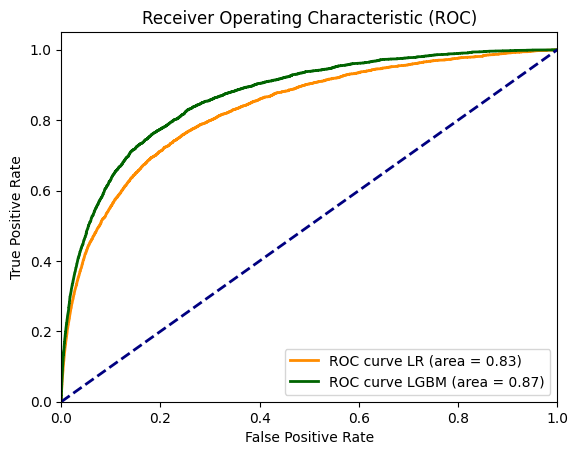

In [14]:
# Plot the ROC curve
plt.figure()
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label=f'ROC curve LR (area = {roc_auc_lr:.2f})')
plt.plot(fpr_lgbm, tpr_lgbm, color='darkgreen', lw=2, label=f'ROC curve LGBM (area = {roc_auc_lgbm:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

Regarding the chosen metric (area under ROC), LGBM is the better model. 

****
### Explainability
****

#### Logistic Regression

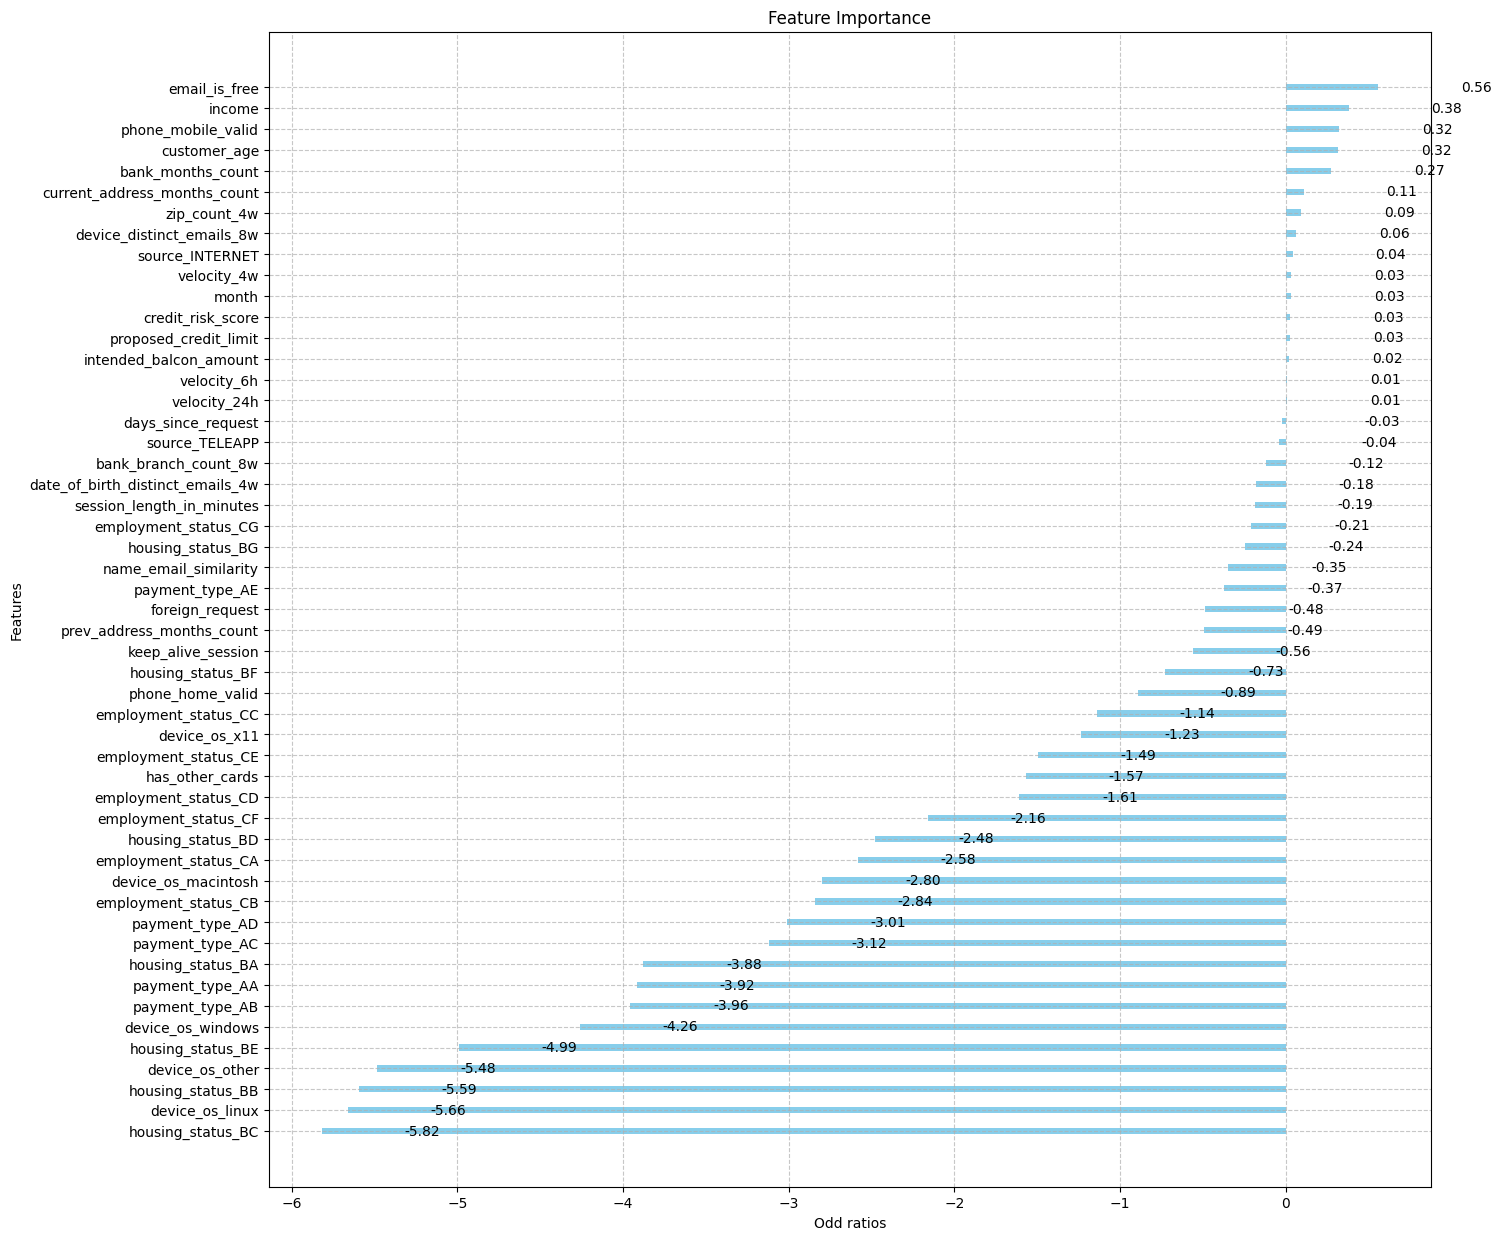

In [66]:
feat_list = []
# Make a dataframe of Coefficients and Feature Names
for feature in zip(X_train, pipeline_lr['log_reg'].coef_[0]):
    feat_list.append(feature)

# create DataFrame using data
df_imp_lr = pd.DataFrame(feat_list, columns =['FEATURE', 'ODDS'])
df_imp_lr = df_imp_lr.sort_values(by="ODDS", ascending = False)

# Create a bar plot
plt.figure(figsize=(15, 15))

bars = plt.barh(df_imp_lr['FEATURE'], df_imp_lr['ODDS'], color='skyblue' , height=0.3)
for bar in bars:
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}', 
             va='center', ha='left', fontsize=10)
    
plt.xlabel('Odd ratios')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y axis to have the highest value on top
plt.grid(linestyle='--', alpha=0.7)
plt.show()

According to the Odd ratios calculated by the logistic regression, a significant amount of features have a strong negative impact on the fraud status. For instance, housing_status = BC decreases significantly the probability to have a fraud. On the contrary, it seems that a greater income increases the probability of commiting a fraud. 

#### LGBM

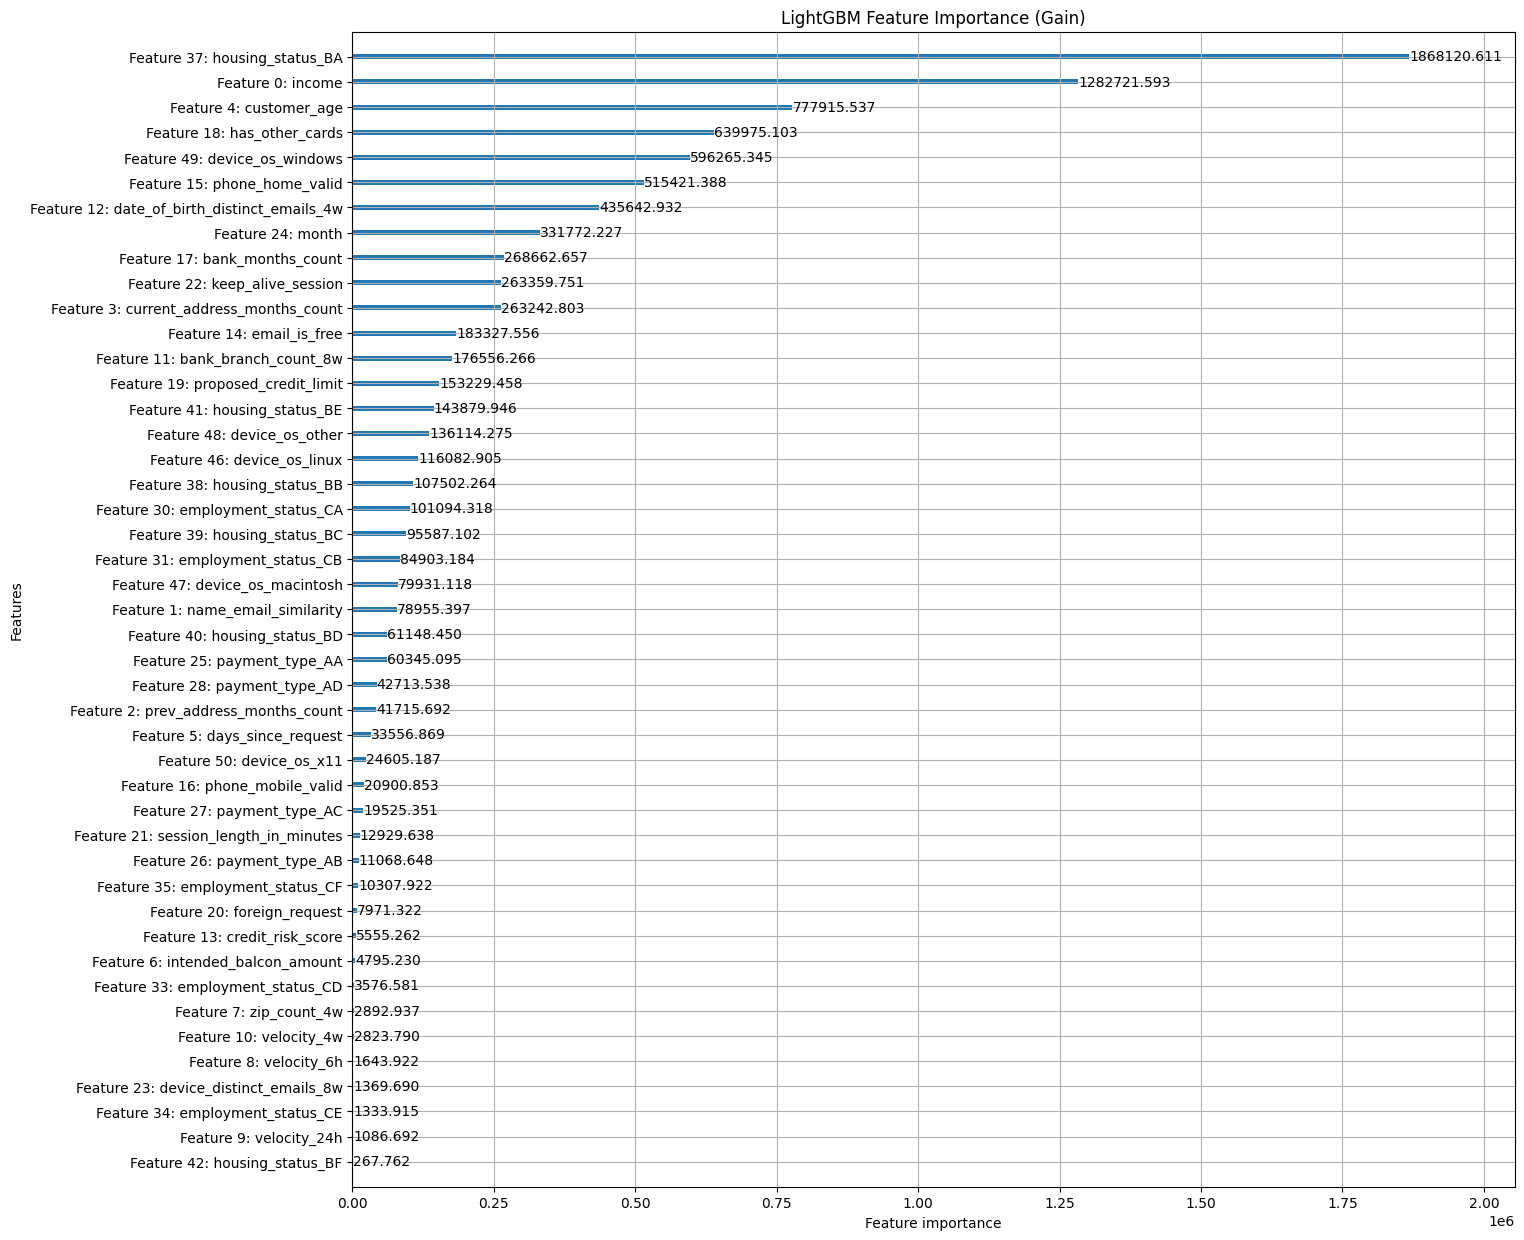

In [67]:
feature_names = X_train.columns
new_labels = {
    i: f"Feature {i}: {name}" for i, name in enumerate(feature_names)
}

# Plot the importance
fig, ax = plt.subplots(figsize=(15, 15))
plot_importance(pipeline_lgbm["lgbm"], importance_type="gain", ax=ax, title="LightGBM Feature Importance (Gain)")
#Gain importance quantifies the improvement in accuracy by using a particular feature for splitting. 

# Modify the y-axis labels
ax.set_yticklabels([new_labels[int(label.get_text().split("_")[1])] for label in ax.get_yticklabels()])

plt.show()

We plot the "Gain" importance score for LGBM. It quantifies the improvement in the model’s accuracy achieved by using a particular feature for splitting the tree. It considers how "useful" is the splits introduce in the tree by this feature. Unlike Odd Ratios in LR, we don't know if the feature positively or negatively influence the probability of fraud. 

It appears that the important features for LGBM are not exactly the same as the ones for LR, even though some of them are common. For instance, income seems also to have a great influence in predicting a fraud. 

We could also use the SHAP library to dig more into explainability, or to use some sensitivity analysis algorithms. 